In [1]:
# ------------------------------------------------------------
# ライブラリのインポート
# ------------------------------------------------------------
# ・LinearRegression
#     → 合成対照法（Synthetic Control）を「回帰モデル」として実装するときに用いる。
#       ここでは、介入前の期間のデータを使って
#       「処置群 = 対照群の線形結合」で近似するための重みを学習する役割を担う。
#
# ・causalpy
#     → ベイズ因果推論や DiD / 合成対照法などを、
#       統一的なインターフェースで扱うためのライブラリ。
#       `cp.load_data("sc")` は、合成対照法用のサンプルデータセットを返すユーティリティ。
from sklearn.linear_model import LinearRegression
import causalpy as cp

# ------------------------------------------------------------
# データのロード
# ------------------------------------------------------------
# cp.load_data("sc"):
#   "sc" は "synthetic control" の略で、合成対照法を学ぶためのサンプルデータ。
#   典型的には、
#     - 1 つの「処置を受けるユニット」（介入後に政策や施策が適用される地域・企業など）
#     - 複数の「対照ユニット」（介入を受けない他地域・他企業）
#     - 時系列軸（t）
#     - アウトカム（y）
#   から構成されるパネルデータになっていることが多い。
#
# 合成対照法のアイデア：
#   介入前の期間だけに着目し、
#   「処置ユニット = 対照ユニットの線形結合」でよく近似できるような重みベクトル w を学習し、
#   その w を介入後にも適用することで
#     ・『介入がなかった場合の処置ユニットのパス（合成対照）』
#   を構成し、観測された実際のパスとの差を因果効果として解釈する。
df = cp.load_data("sc")

# ------------------------------------------------------------
# 処置のタイミングの設定
# ------------------------------------------------------------
# treatment_time = 70:
#   時間軸 t 上で「いつ介入が発生したか」を示すカットポイント。
#   ここでは
#       t < 70  → 介入前期間（pre-intervention）
#       t >= 70 → 介入後期間（post-intervention）
#   とみなす想定。
#
# 合成対照法の推定では通常、
#   ・t < treatment_time のデータのみを使って重み w を学習（前期フィット）
#   ・t >= treatment_time では、その w により合成対照のアウトカムを予測し、
#     処置ユニットとの乖離を「ポスト期間の因果効果」として評価する。
treatment_time = 70

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# ------------------------------------------------------------
# 合成コントロール法による因果効果の推定
# ------------------------------------------------------------
# SyntheticControl クラスは、いわゆる「合成対照法」を
# sklearn 風のインターフェースで扱うためのラッパ。
#
# 合成対照法の基本アイデア：
#   - 介入を受けるユニット（ここでは actual）と、
#     介入を受けない複数の対照ユニット（a〜g）があるとする。
#   - 介入“前”の期間だけを使って、
#
#       actual_t ≈ w_a * a_t + w_b * b_t + ... + w_g * g_t
#
#     となるような重みベクトル w = (w_a, ..., w_g) を学習する。
#   - この w を介入“後”にもそのまま適用して、
#
#       synthetic_t = w_a * a_t + ... + w_g * g_t
#
#     を「介入がなかった世界の actual（反事実）」として構成し、
#       actual_t - synthetic_t
#     を因果効果（介入効果）として解釈する。
#
# 下の SyntheticControl は、この一連の手続きを内部でやってくれる。
result = cp.skl_experiments.SyntheticControl(
    df,
    # --------------------------------------------------------
    # treatment_time:
    # --------------------------------------------------------
    # 介入発生時点（カットオフ）の指定。
    #   t < treatment_time  : 介入前（pre）
    #   t >= treatment_time : 介入後（post）
    # 合成対照法では、
    #   - pre 期間 → 重み w の推定にのみ使用
    #   - post 期間 → 推定された w から synthetic を構成し、
    #                 actual との差を因果効果として評価
    treatment_time,
    # --------------------------------------------------------
    # formula: R 風の回帰式で、処置ユニットと対照ユニットの関係を記述
    # --------------------------------------------------------
    # "actual ~ 0 + a + b + c + d + e + f + g"
    #
    # ・左辺 `actual`
    #   → 処置ユニットのアウトカム（例：処置を受ける店舗の売上）。
    #
    # ・右辺 `0 + a + ... + g`
    #   - 0:
    #       切片（intercept）を含めない指定。
    #       これにより、「actual を対照ユニットの線形結合だけで説明する」
    #       という形になる。
    #       合成対照法では「重み付き平均で actual を近似する」という
    #       解釈を明確にするため、切片を 0 にするのが典型。
    #   - a, b, ..., g:
    #       それぞれ対照ユニットのアウトカム（例：他店舗の売上）を表す列。
    #       これらの非負重み付き和で actual を近似する。
    #
    # 理論的には、
    #
    #   $$ \text{actual}_t \approx \sum_{j \in \{a,\dots,g\}} w_j \cdot X_{j,t} $$
    #
    # となるような w を pre 期間で学習し、
    # post 期間では
    #
    #   $$ \widehat{\text{synthetic}}_t
    #       = \sum_{j} \hat{w}_j \cdot X_{j,t} $$
    #
    # を「反事実のパス」として用いる。
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    # --------------------------------------------------------
    # model: 重みの構造をどう制約するか（WeightedProportion）
    # --------------------------------------------------------
    # WeightedProportion:
    #   - 重みが 0 以上
    #   - 重みの総和が 1
    # という「確率分布」のような制約を課すモデル。
    #
    # これにより、合成対照は
    #
    #   「対照ユニット a〜g の凸結合（convex combination）」
    #
    # となり、
    #   - synthetic のスケールが actual と自然に揃う
    #   - どの対照ユニットも負の重みを持たない（解釈がしやすい）
    # といった利点がある。
    #
    # 理論的には、
    #   「処置ユニットは、対照ユニット集合の凸包の中で近似できる」
    # という仮定の下で、
    #   - pre 期間における actual と synthetic の乖離が小さいほど、
    #   - post 期間における actual − synthetic を
    #     因果効果として信頼してよい
    # という考え方になる。
    model=cp.skl_models.WeightedProportion(),
)

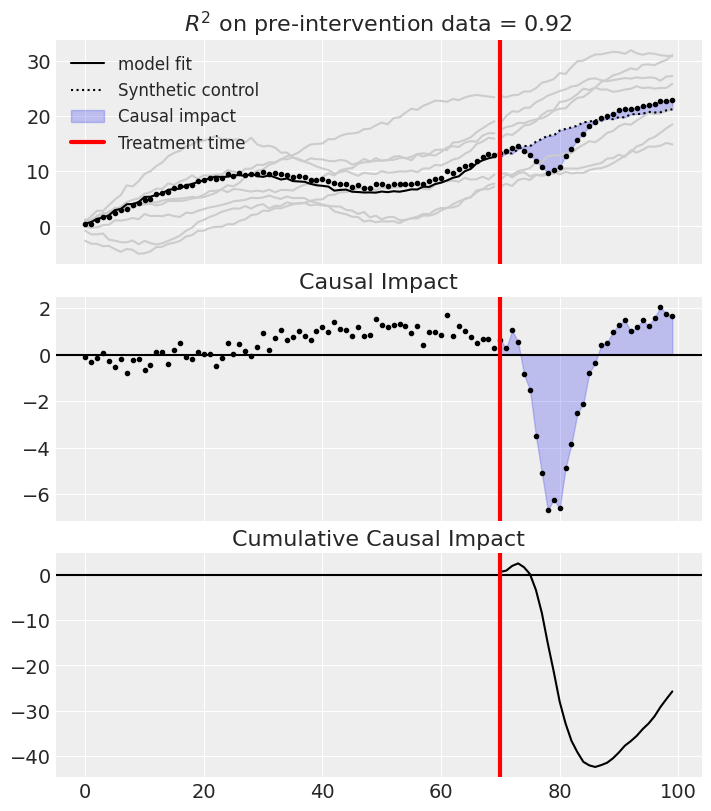

In [3]:
# ------------------------------------------------------------
# 結果の可視化（合成対照パス vs 実測パス）
# ------------------------------------------------------------
# result.plot():
#   合成コントロール法の中心的なアウトプットである
#   「処置ユニットの実測パス」と「合成対照パス」を
#   同じグラフ上に描画する。
#
#   ・横軸：時間（ここでは日付インデックス）
#   ・縦軸：アウトカム（売上など）
#   ・縦の実線または点線：介入時点（treatment_time）
#   ・青線など：処置ユニット actual の時系列
#   ・オレンジ線など：合成対照 synthetic の時系列
#
#   介入前（pre）の区間で actual と synthetic がよく重なっていればいるほど、
#   「対照ユニットの凸結合で処置ユニットをうまく近似できている」
#   ＝「この重み w を使って反事実を推定するのは妥当そうだ」
#   と判断できる。
#
#   介入後（post）の区間では、
#       actual_t - synthetic_t
#   の差が「介入がなかった世界と比べた因果効果」として解釈される。
#
# plot_predictors=True:
#   True にすると、アウトカム系列だけでなく
#   「合成対照を構成する際に使われた各対照ユニットの寄与（predictor）」も
#   追加で描画する設定。
#
#   これにより、
#   - どのユニット（a〜g）がどれだけの重みを持っているか
#   - どのユニットが合成対照の形状に主に寄与しているか
#   を視覚的に確認でき、重み w の解釈がしやすくなる。
#
#   研究ノートや README では、
#     ・pre 期間におけるフィットの良さ
#     ・post 期間における actual − synthetic のギャップ
#   をスクリーンショット付きで説明すると、
#   「合成対照法が何をしているか」が一目で伝わる。
fig, ax = result.plot(plot_predictors=True)

/Users/maton/Causal_Interface_Practice/.venv/lib/python3.9/site-packages/causalpy/skl_experiments.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/Users/maton/Causal_Interface_Practice/.venv/lib/python3.9/site-packages/causalpy/skl_experiments.py:204: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


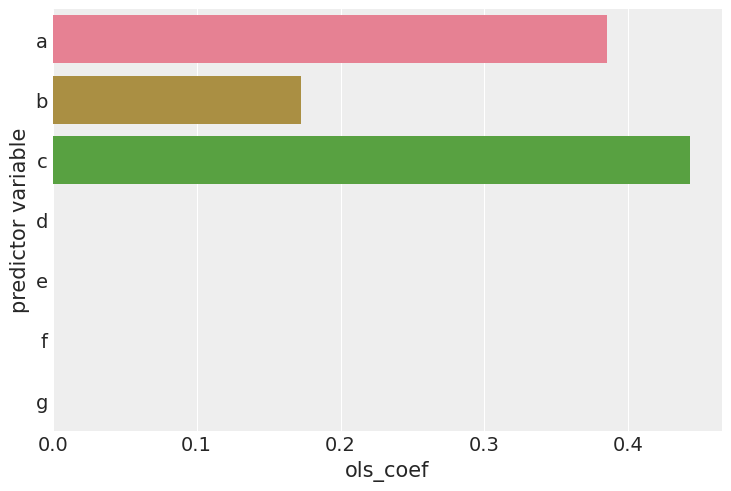

In [4]:
# ------------------------------------------------------------
# 合成対照を構成する係数（重み）の可視化
# ------------------------------------------------------------
# SyntheticControl では、
#   ・処置ユニット actual
#   ・対照ユニット a〜g
# に対して、介入“前”の期間だけを使って
#
#   actual_t ≈ w_a * a_t + w_b * b_t + ... + w_g * g_t
#
# となるような重みベクトル w = (w_a, ..., w_g) を推定している。
#
# ここで使っている WeightedProportion モデルは
#   ・w_j ≥ 0   （非負）
#   ・∑_j w_j = 1 （総和 1）
# という「確率分布」のような制約を課しているため、
#   - 「どの対照ユニットが、どれだけの割合で合成対照を構成しているか」
# を重みとして自然に解釈できる。
#
# result.plot_coeffs():
#   推定された各対照ユニット a〜g の係数 w_j を棒グラフなどで可視化するメソッド。
#
# このプロットから読み取れること：
#   - ほぼ 1.0 に近い重みを持つユニットがあれば、
#       → 実質的にそのユニット単体が「コントロール」として振る舞っている
#   - 複数のユニットに分散した重みになっていれば、
#       → 「複数の類似ユニットの凸結合」として処置ユニットを近似している
#   - 重みが極端（ほぼ 0 か 1）になりすぎていないかをチェックすることで、
#       → 合成対照のロバストさ・解釈可能性を診断できる
#
# 理論的には、
#   - pre 期間の actual と synthetic のフィットが良好
#   - plot_coeffs で表示される重みが「ドメイン的に納得できる組み合わせ」
# であればあるほど、
#   post 期間における
#       actual_t - synthetic_t
#   を「介入の因果効果」として解釈する根拠が強くなる。
result.plot_coeffs()